In [2]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
G = nx.read_graphml('data/arrietta-orritz-delta6-rnaseq-annotated.graphml')

## Changes in sporulation
Let's first see how many of each of our treatments involve changes in sporulation genes. This is not really a network problem but it gives us a starting point.

In [5]:
# network x nodes method returns a tuple with node label and attribute dict
# everything we need is in the attribute dict
node_list = [tup[1] for tup in G.nodes(data=True)]
df = pd.DataFrame(node_list)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2932 entries, 0 to 2931
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   SUID                     2932 non-null   int64  
 1   shared name              2932 non-null   object 
 2   name                     2932 non-null   object 
 3   selected                 2932 non-null   bool   
 4   EdgeCount                2932 non-null   int64  
 5   Indegree                 2932 non-null   int64  
 6   Outdegree                2932 non-null   int64  
 7   activity                 2932 non-null   object 
 8   canonicalName            2932 non-null   object 
 9   geneName                 2932 non-null   object 
 10  locus_tag.d6             2932 non-null   object 
 11  sporulation              2932 non-null   int64  
 12  Goe3_log2_fold_change    2932 non-null   float64
 13  sigF_log2_fold_change    2932 non-null   float64
 14  sigG_log2_fold_change   

We'll need to get a baseline for each treatment by randomly selecting the same number of affected nodes and counting how many of them are involved in sporulation.

In [6]:
treatments = ['sigF', 'sigG', 'Goe3', 'SP10', 'pDR110']
tr_sizes = []

# number of genes in treatment that do sporulation
tr_spor = []
for tr in treatments:
    tr_sizes.append(df[df[tr + '_log2_fold_change'] != 0].shape[0])
    tr_spor.append(df[(df[tr + '_log2_fold_change'] != 0) & (df['sporulation'] == 1)].shape[0])
print(tr_sizes, tr_spor)

[949, 718, 11, 23, 0] [293, 245, 6, 1, 0]


So we can forget about the pDR110 treatment because it showed no significant changes. For the rest lets see how the look visually. First we need to use bootstrapping to find the null hypothesis that the treatments do not favor sporulation. Then we can see where our experimental results lie with respect to that measure.

In [7]:
# get an array of sporulation activity to sample from
sporulation = df['sporulation'].values

tr_counts = []
p_vals = []
for tr in range(len(tr_sizes[:-1])):
    spor_counts = np.zeros(10000)
    for i in range(spor_counts.shape[0]):
        samp = np.random.choice(sporulation, size=tr_sizes[tr], replace=True)
        spor_counts[i] = samp.sum()
    # get chance of seeing a value as extreme as exp value
    p_val = spor_counts[spor_counts > tr_spor[tr]].shape[0] / spor_counts.shape[0]
    p_vals.append(p_val)
    tr_counts.append(spor_counts)


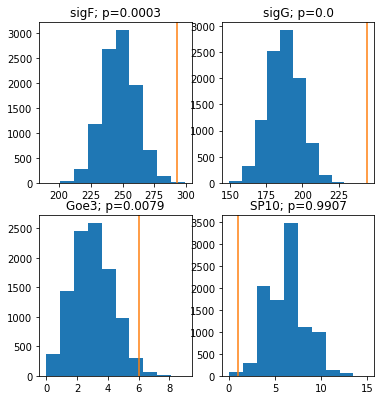

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(6, 6.5))
ax = ax.flatten()
for tr in range(len(tr_sizes[:-1])):
    ax[tr].hist(tr_counts[tr], bins=10)
    ax[tr].axvline(tr_spor[tr], c='C1')
    ax[tr].set_title('{}; p={}'.format(treatments[tr], p_vals[tr]))
    
plt.show()

Ok so this is fine I guess. We have significantly more sporulation genes hit by these sigma factors except for SP10. Thats what we expected so its good that we see it in our data. For the viral factors Goe3 and SP10, we see what feels like an oddly small number. If the network is very degree heterogenoues we would expect regulator nodes to regulate more than just the 16 that we see affected.

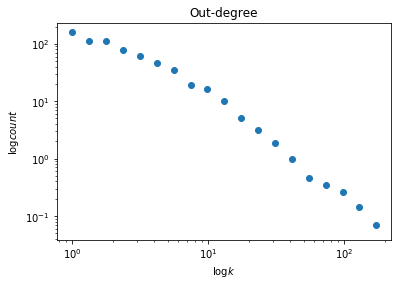

In [9]:
# extract degrees
degree = [k[1] for k in G.out_degree()]
nonzero = [k for k in degree if k > 0]
num_zeros = len([z for z in degree if z == 0])
sorted_degree = sorted(nonzero)

# calculate bins
n_bins = 20
bins = np.logspace(np.log10(sorted_degree[0]), np.log10(sorted_degree[-1]), n_bins, base=10)
counts, bin_edges = np.histogram(sorted_degree, bins)
norm_counts = np.array(counts) / np.diff(np.array(bin_edges))

# count CCDF
ccdf = np.cumsum(norm_counts[::-1])
rev_bins = bin_edges[::-1]

# draw plot
fig, ax = plt.subplots()
ax.scatter(rev_bins[1:], ccdf)
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim((10**-3, 10**5))
# ax.set_xlim((10**-0.1, 10**34))
ax.set_xlabel(r'$\log{k}$')
ax.set_ylabel(r'$\log{count}$')
ax.set_title('Out-degree')
plt.show()

Ok so this is what we expected also. What about the degree of the nodes we see upregulated? We should see something similar because the factors will act on regulators that will act on targets with low or zero out degree. We can't plot zero degree nodes in log-log scale but we can count them.

In [10]:
print('treatment\t# zeros\tunique values')
print('-'*40)
for tr in range(len(treatments)):
    change_col = treatments[tr] + '_log2_fold_change'
    out_degree = df[df[change_col] != 0]['Outdegree'].values
    unique = np.unique(out_degree)
    num_zeros = out_degree[out_degree == 0].shape[0]
    print('{}\t{}\t{}'.format(treatments[tr], num_zeros, unique))

treatment	# zeros	unique values
----------------------------------------
sigF	916	[ 0  1  2  3  4  5  7  9 10 12 13 29 30 35]
sigG	696	[ 0  1  2  3  4  5  6  7  9 10 11 12 16 29 35]
Goe3	11	[0]
SP10	22	[ 0 39]
pDR110	0	[]


So almost all of our nodes have out-degree zero. This makes sense, it is the most common out degree in our network. What might be weird is if we have a bunch of target genes affected without any regulators affected. Something we can check is whether the affected genes are closer than expected in our network.

In [13]:
# calculate path lengths between each pair of nodes on an undirected version of the giant component
#otherwise we probably will not have paths for most pairs
undirect_giant = nx.Graph(G)
cc = max(nx.connected_components(undirect_giant), key=len)
undirect_giant = undirect_giant.subgraph(cc)
avg_distance = []
for tr in range(len(treatments[:-1])):
    change_col = treatments[tr] + '_log2_fold_change'
    changed_genes = df[df[change_col] != 0]['SUID'].values
    path_lengths = []
    for genei in changed_genes:
        for genej in changed_genes:
            # no sense in finding path lengths of zero
            if str(genei) in undirect_giant and str(genej) in undirect_giant:
                if genei != genej:
                    path_lengths.append(nx.shortest_path_length(undirect_giant, str(genei), str(genej)))
    avg_distance.append(np.mean(path_lengths))

# we also need the distribution of path lengths for the entire network
total_path_lengths = nx.shortest_path_length(nx.Graph(undirect_giant))
length_list = []
for t in dict(total_path_lengths).values():
    length_list.extend(list(t.values()))

In [14]:
print(avg_distance)

[4.661378184386148, 4.5462881481927955, 4.3090909090909095, 5.075098814229249]


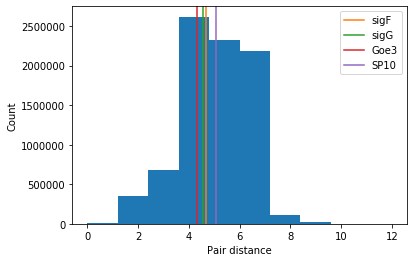

In [16]:
plt.hist(length_list)
colors=['C1', 'C2', 'C3', 'C4']
for c in range(len(colors)):
    plt.axvline(avg_distance[c], c=colors[c], label=treatments[c])
plt.legend()
plt.xlabel('Pair distance')
plt.ylabel('Count')
plt.show()

Ok so this is fine I guess. We have significantly more sporulation genes hit by these sigma factors except for SP10. What does it look like if we restrict our analysis to the giant component of only the sporulation genes. We can probably just think of this as our sporulation related genes.

In [61]:
spor_component = G.copy()
drop_nodes = df[df['sporulation'] == 0]['SUID'].values
spor_component.remove_nodes_from(drop_nodes.astype(str))
cc = max(nx.weakly_connected_components(spor_component), key=len)
SC = spor_component.subgraph(cc)

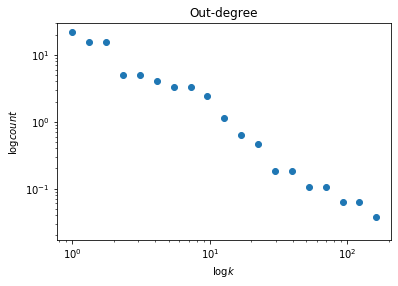

In [72]:
# extract degrees
degree = [k[1] for k in SC.out_degree()]
nonzero = [k for k in degree if k > 0]
num_zeros = len([z for z in degree if z == 0])
sorted_degree = sorted(nonzero)

# calculate bins
n_bins = 20
bins = np.logspace(np.log10(sorted_degree[0]), np.log10(sorted_degree[-1]), n_bins, base=10)
counts, bin_edges = np.histogram(sorted_degree, bins)
norm_counts = np.array(counts) / np.diff(np.array(bin_edges))

# count CCDF
ccdf = np.cumsum(norm_counts[::-1])
rev_bins = bin_edges[::-1]

# draw plot
fig, ax = plt.subplots()
ax.scatter(rev_bins[1:], ccdf)
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim((10**-3, 10**5))
# ax.set_xlim((10**-0.1, 10**34))
ax.set_xlabel(r'$\log{k}$')
ax.set_ylabel(r'$\log{count}$')
ax.set_title('Out-degree')
plt.show()

In-degree is funky because we have a max of 3. The plot doesnt look right at all.

In [76]:
# extract degrees
degree = [k[1] for k in SC.in_degree()]
sorted_degree = sorted(degree)
print(sorted_degree)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 